# 0 - Initializations

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import csv

from pylab import rcParams
import seaborn as sns
import math
import os
from datetime import datetime,  timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
 
from matplotlib import pyplot

from solarpy import irradiance_on_plane
from solarpy import solar_panel
from numpy import array

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, GlobalMaxPooling1D, RepeatVector, Lambda, TimeDistributed, Embedding, TimeDistributed, BatchNormalization, Reshape, concatenate, Permute
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.backend import square, mean


from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.utils import to_categorical

from keras.utils.vis_utils import plot_model


#Uncomment to use database file - access to remote database
#%run Database.ipynb
%run AuxFunctions.ipynb

plt.rcParams.update({'figure.figsize':(8,4), 'figure.dpi':300})

Using TensorFlow backend.


Collect from EDP database - True / Collect from local files - False

In [2]:
df_pv, df_consumption = collectFromDatabase(False)

In [3]:
dfinal = getData(local = True)

Data manipulation

In [4]:
dataset1 = np.genfromtxt('dados__Rad.dat', delimiter=',', skip_header=3, missing_values='Missing',names=True,dtype=None)
dataset2 = np.genfromtxt('dados__Met.dat', delimiter=',', skip_header=3, missing_values='Missing',names=True,dtype=None)

df1 = pd.DataFrame(data=dataset1)
df2 = pd.DataFrame(data=dataset2)

df1.columns = ["Timestamp","RECORD","Avg_GHI","Avg_DHI","Avg_POA","Avg_DNI","Avg_cosDNI","Avg_closGHI","Std_GHI","Std_DHI","Std_POA","Std_DNI","Std_cosDNI","Std_closGHI","Min_GHI","Min_DHI","Min_POA","Min_DNI","Min_cosDNI","Min_closGHI","Max_GHI","Max_DHI","Max_POA","Max_DNI","Max_cosDNI","Max_closGHI","phi","theta","SensorT"]
df2.columns = ["Timestamp","RECORD","T_amb_min","T_amb_max","T_amb_avg","T_dp_avg","RH_min","RH_max","RH_avg","AH_min","AH_max","AH_avg","p_amb_min","p_amb_max","p_amb_avg","rho_act","v_min","v_max","v_avg","v_vectavg","v_dir_min","v_dir_max","v_dir_vectavg"]

df1['Timestamp'] = pd.to_datetime(df1['Timestamp'].str.decode("utf-8"), format='"%Y-%m-%d %H:%M:%S"')
df2['Timestamp'] = pd.to_datetime(df2['Timestamp'].str.decode("utf-8"), format='"%Y-%m-%d %H:%M:%S"')
df3 = pd.merge(df1,df2, how='inner', left_index=True, right_index=True)

C:\Users\tomas\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """Entry point for launching an IPython kernel.
C:\Users\tomas\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  


Feature selection and data type selection

In [5]:
PV = df_pv.copy()
consumption = df_consumption.copy()

consumption = consumption.set_index('Timestamp')
df3.rename(columns={"Timestamp_x": "Timestamp", "RECORD_x": "Record"}, inplace=True)

PV['Timestamp'] = PV['Timestamp'].dt.round('min')
PV = PV.groupby('Timestamp').mean().reset_index()
PV = PV.set_index('Timestamp')

idx = pd.period_range(PV.index[0], PV.index[-1], freq='min')
idy = pd.period_range(consumption.index[0], consumption.index[-1], freq='min')

PV = PV.reset_index()
PV = PV.set_index('Timestamp').resample("min").first().reset_index().reindex(columns=PV.columns)
cols = PV.columns.difference(['I1', 'I2', 'I3', 'V1', 'V2', 'V3', 'ActPwr'])
PV[cols] = PV[cols].ffill()
PV['ActPwr'] = PV['ActPwr']*1000

consumption = consumption.reset_index()
consumption = consumption.set_index('Timestamp').resample("min").first().reset_index().reindex(columns=consumption.columns)
cols = consumption.columns.difference(['Ir','Is','It','Vrs','Vst','Vtr','P','S'])
consumption[cols] = consumption[cols].ffill()

consumption = consumption.set_index('Timestamp')
df3 = df3.set_index('Timestamp')

PV_original = PV.copy()
PV = PV_original[['Timestamp', 'ActPwr']].copy()

consumption_original = consumption.copy()
consumption = consumption_original[['P']]

Sun irradiation theoretical computation

In [6]:
panel = solar_panel(500, 0.15, id_name='EDP')  # surface, efficiency and name
panel.set_orientation(array([0, 0, -1]))  # upwards
panel.set_position(38.707089, -9.148882, 0)  # LISBON latitude, longitude, altitude

In [7]:
PV = PV.reset_index()
PV['Theoretical Value'] = PV['Timestamp'].apply(lambda x: fnc(x.year, x.month, x.day, x.hour, x.minute))# year, month, day, hour, minute
PV = PV.set_index('Timestamp')

In [8]:
PV['Theoretical Value'] = PV['Theoretical Value'].shift(60, axis = 0) #passar tudo para UTC
PV = PV.replace(np.nan, '-1')
#PV.to_csv("PV.csv")

# Merge meteo and PV datasets

In [9]:
PREV = df4 = pd.merge(df3, PV, left_index=True, right_index=True)

In [10]:
PREV = PREV.drop(columns=['Timestamp_y', 'RECORD_y'])

In [11]:
PREV = PREV[['Avg_DHI', 'Avg_GHI', 'Avg_DNI', 'Avg_POA', \
             'T_amb_avg','RH_avg', 'AH_avg', 'p_amb_avg', 'rho_act', 'v_avg', 'v_dir_vectavg',    \
             'Theoretical Value', 'ActPwr']].copy()

In [12]:
PREV = PREV.replace('-1', np.nan)

# Data interpolation


Adding 0's when there is no sun

In [13]:
NOITE = PREV.copy()
NOITE['ActPwr_noite'] = NOITE.apply(f, axis=1)

In [14]:
dataaux = NOITE.copy()

Interpolations for gaps of less than 30 minutes

In [15]:
INT = NOITE.copy()
INT['Interpolation'] = INT['ActPwr_noite'].interpolate(method='polynomial', limit=30, order=2)

In [16]:
dataaux['Interpolation'] = INT['Interpolation'].copy()

In [17]:
INT['Interpolation'] = INT['Interpolation'].replace(np.nan, '-1000')
INT['Interpolation_Final'] = INT.apply(s, axis=1)
INT['Interpolation'] = INT['Interpolation'].replace('-1000',np.nan)

print(INT.ActPwr.count()/INT['Theoretical Value'].count() * 100)
print(INT.ActPwr_noite.count()/INT['Theoretical Value'].count() * 100)
print(INT.Interpolation.count()/INT['Theoretical Value'].count() * 100)

23.68818422046055
57.52340021875696
59.75888337156741


# Dfinal -> Merge PV and Consumption datasets

In [18]:
INT = INT.drop(['ActPwr', 'ActPwr_noite', 'Interpolation'], axis=1)
INT = INT.rename(columns={"Interpolation_Final": "ActPwr"})

In [19]:
consumption = consumption.interpolate(method='polynomial', limit=30, order=2)

dfinal = pd.concat([INT, consumption], axis=1, sort = False, join = 'inner')
dfinal = dfinal.rename(columns={"Interpolation_Final": "ActPwr"})
dfinal = dfinal.reset_index()
dfinal = dfinal.set_index('Timestamp')

In [20]:
dataaux['ActPwr_final'] = dfinal['ActPwr'].copy()

Data completion visualization

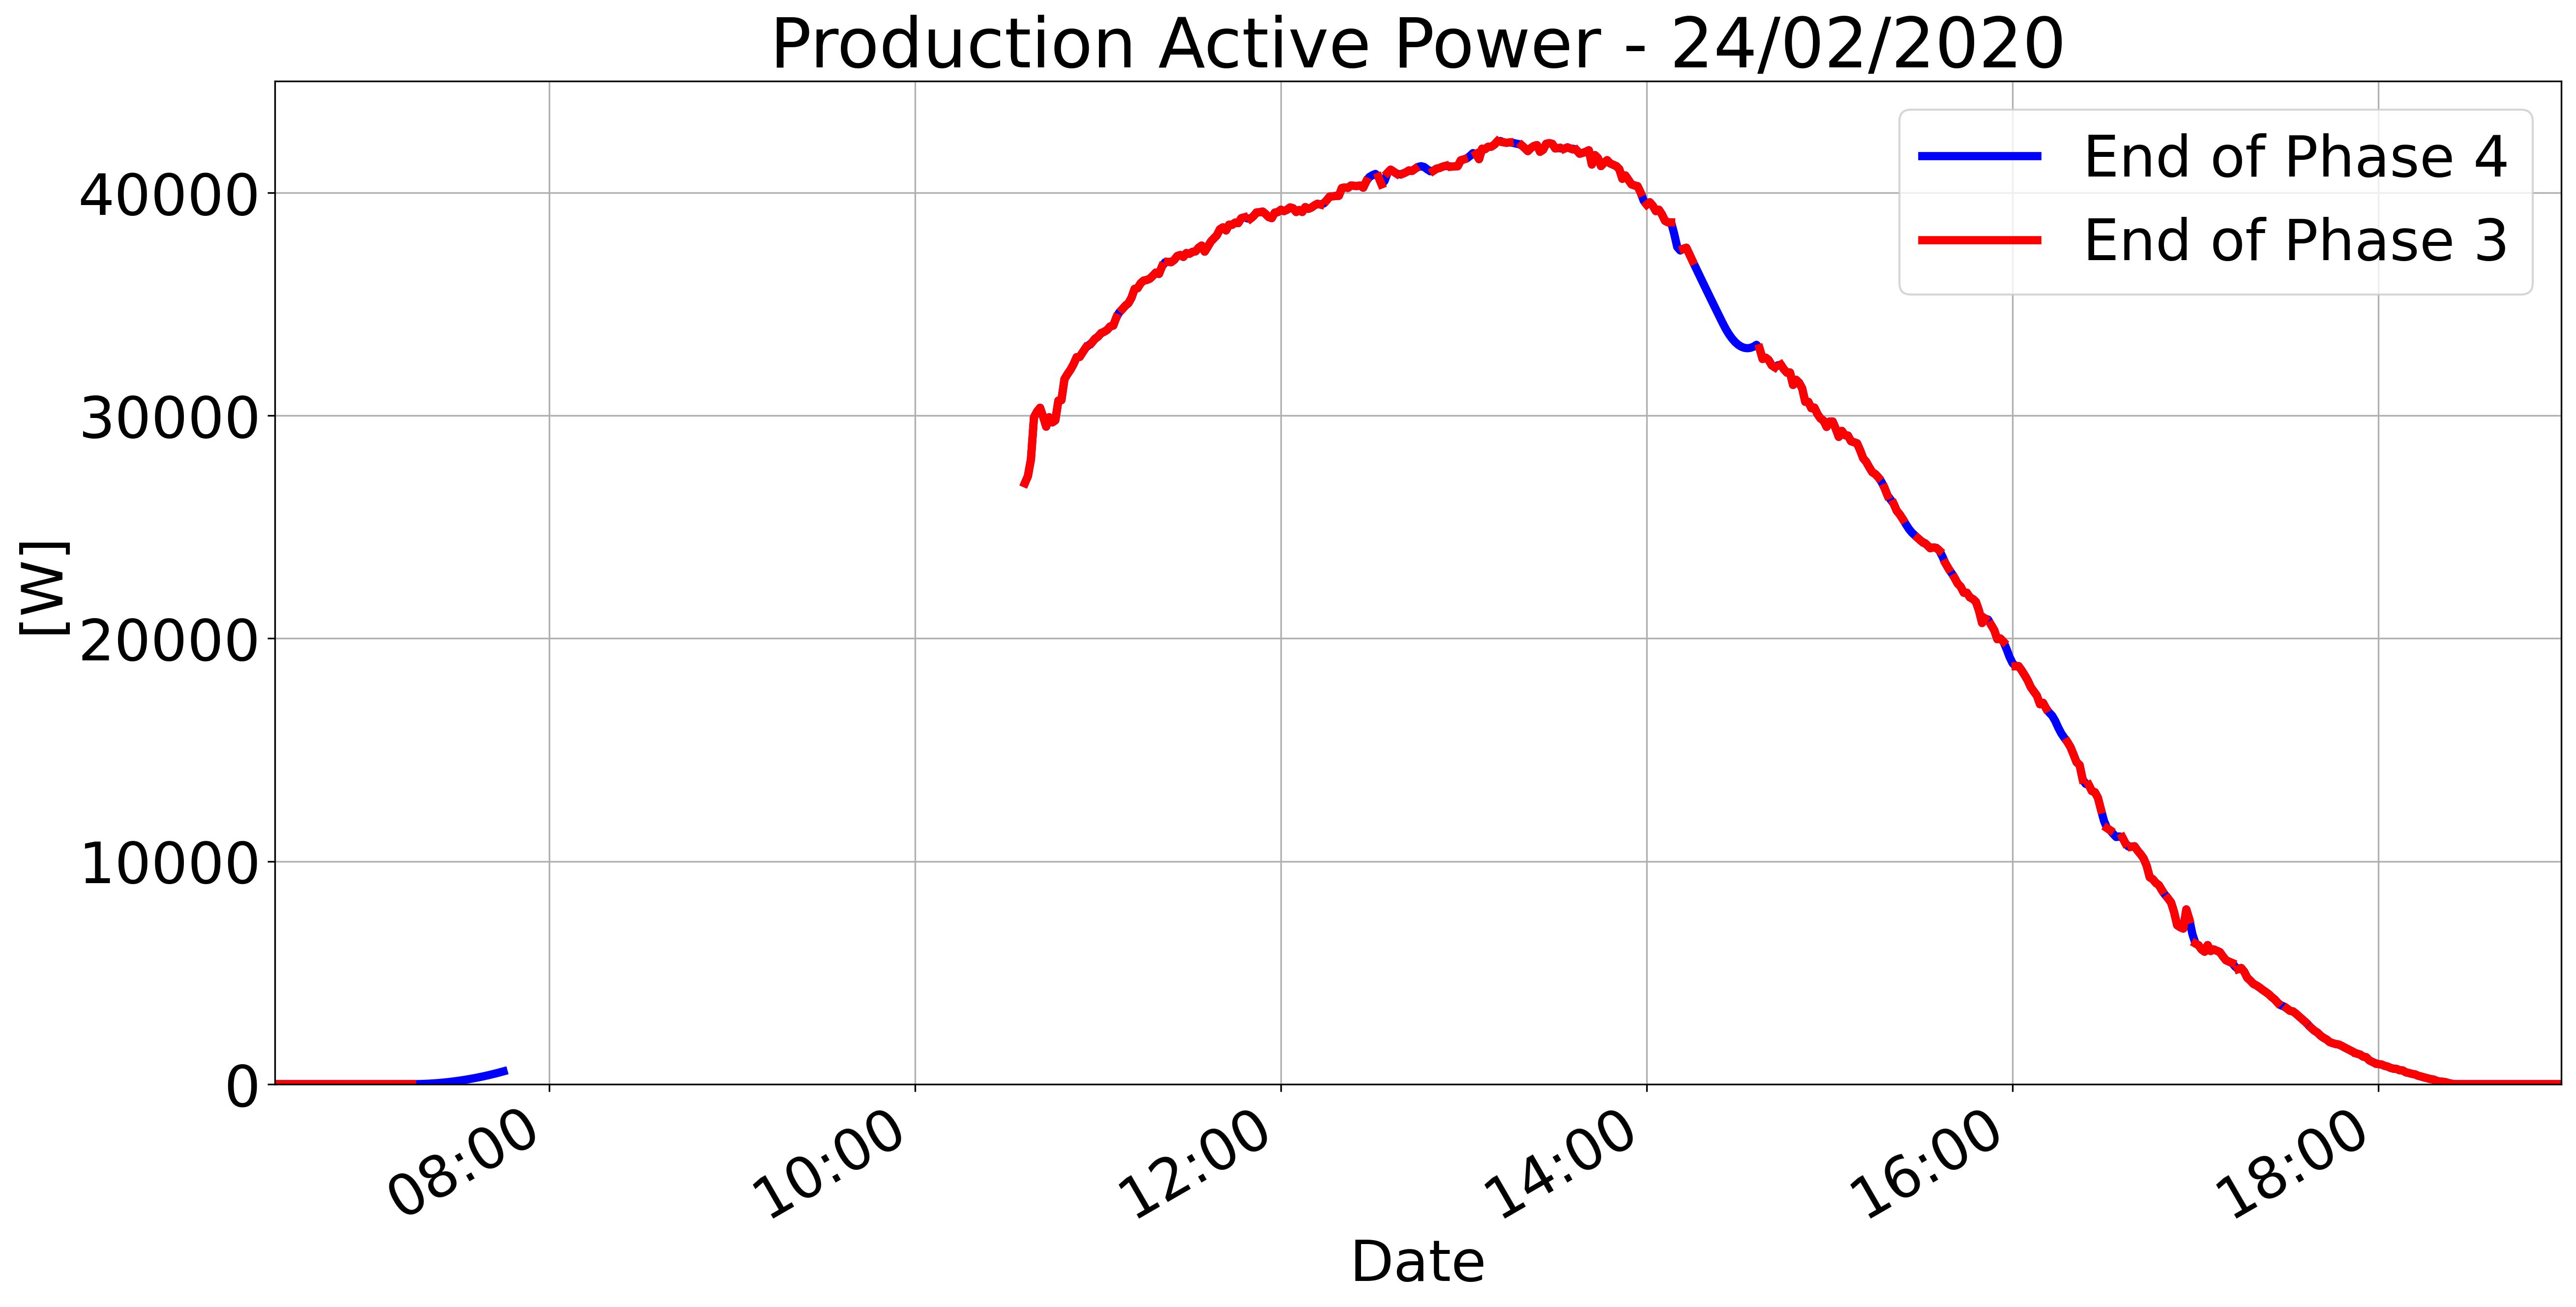

In [21]:
plt.rcParams.update({'figure.figsize':(20,10), 'figure.dpi':300})
font = {'weight' : 'normal','size'   : 28}
plt.rc('font', **font)
pyplot.figure()

#dataaux['ActPwr_final'].plot(label='End of Phase 5', linewidth=4, color='green')
dataaux['Interpolation'].plot(label='End of Phase 4', color='blue', linewidth=4)
dataaux['ActPwr_noite'].plot(label='End of Phase 3',linewidth=4, color='red')

plt.title('Production Active Power - 24/02/2020')
plt.xlim('02/24/2020 06:30', '02/24/2020 19:00')
plt.ylim(-5,45000 )
plt.xlabel('Date')
plt.ylabel('[W]')
plt.legend()

import matplotlib.dates as md
ax=plt.gca()
xfmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)


axes = plt.gca()
plt.grid()
plt.savefig("2", bbox_inches = 'tight')
pyplot.show()

In [22]:
dfinal = dfinal[11520:53280]

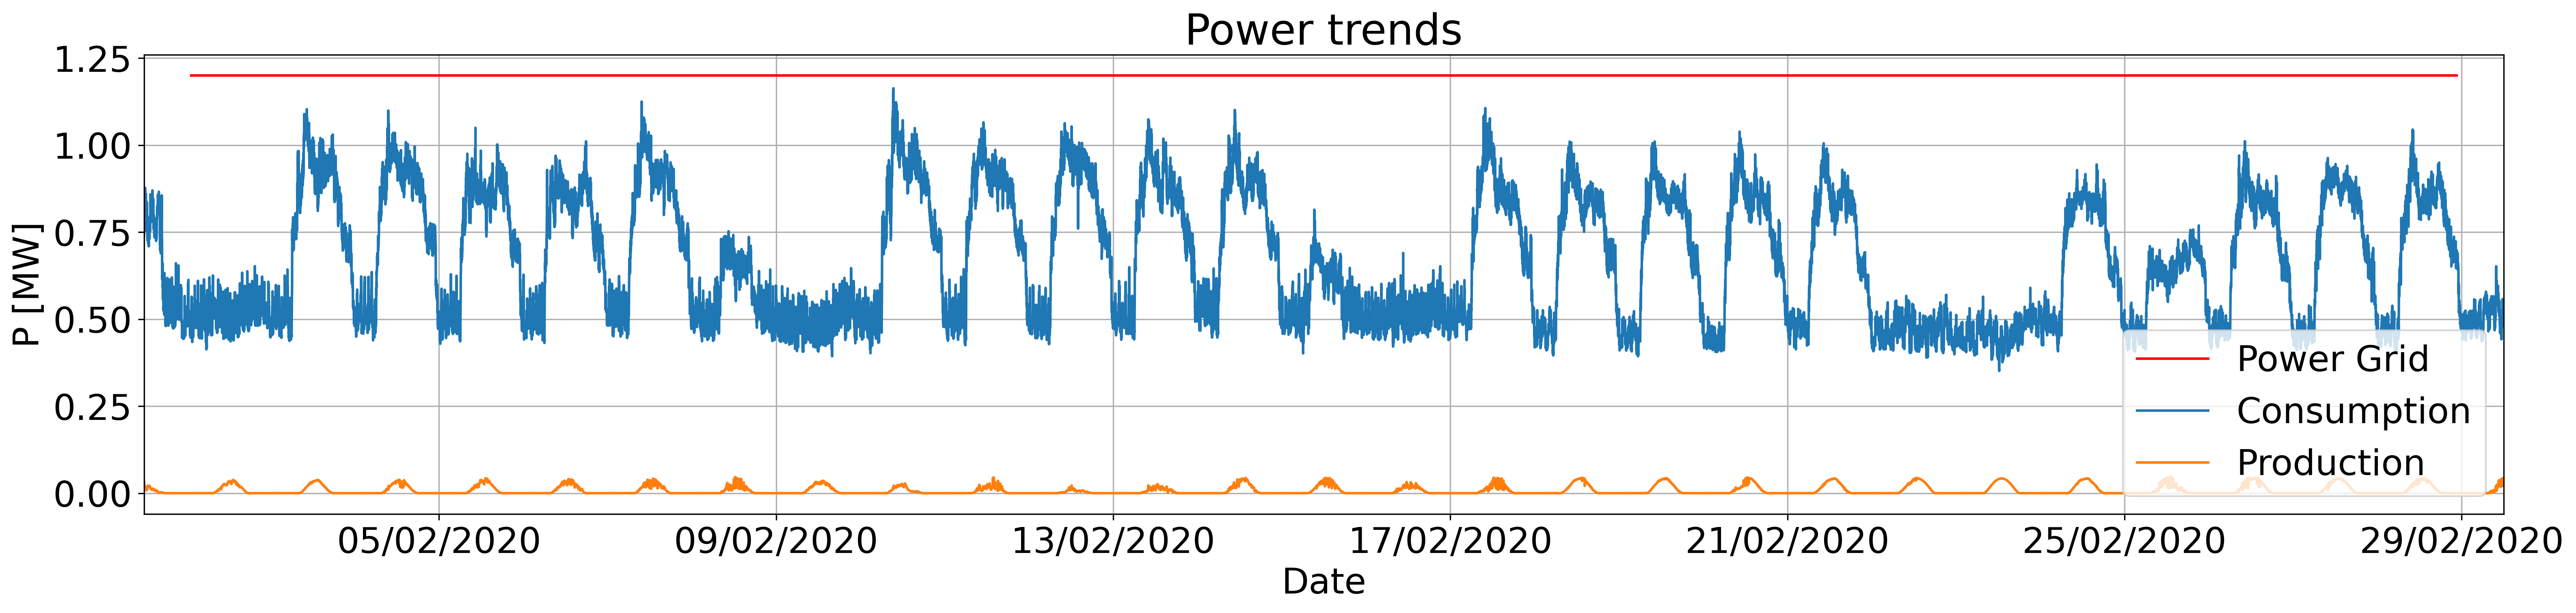

In [23]:
plt.figure(figsize=(25, 5) )

font = {'weight' : 'normal','size'   : 21}
plt.rc('font', **font)
plt.xlim(737456.5, 737484.5)

plt.axhline(y=1200000/1000000, xmin=0.02, xmax=0.98, color='r', label='Power Grid')
plt.plot(dfinal.index, dfinal.P/1000000, label='Consumption')
plt.plot(dfinal.index, dfinal.ActPwr/1000000, label='Production')
plt.xlabel('Date')
plt.ylabel('P [MW]')
plt.title('Power trends')
plt.legend(loc = 'lower right')
plt.grid()



import matplotlib.dates as md
ax=plt.gca()
xfmt = md.DateFormatter('%d/%m/%Y')
ax.xaxis.set_major_formatter(xfmt)


axes = plt.gca()
plt.savefig("Max_cons_prod", bbox_inches = 'tight')

In [24]:
dfinal['AvailablePower'] = 1200000 - dfinal['P'] + dfinal['ActPwr']

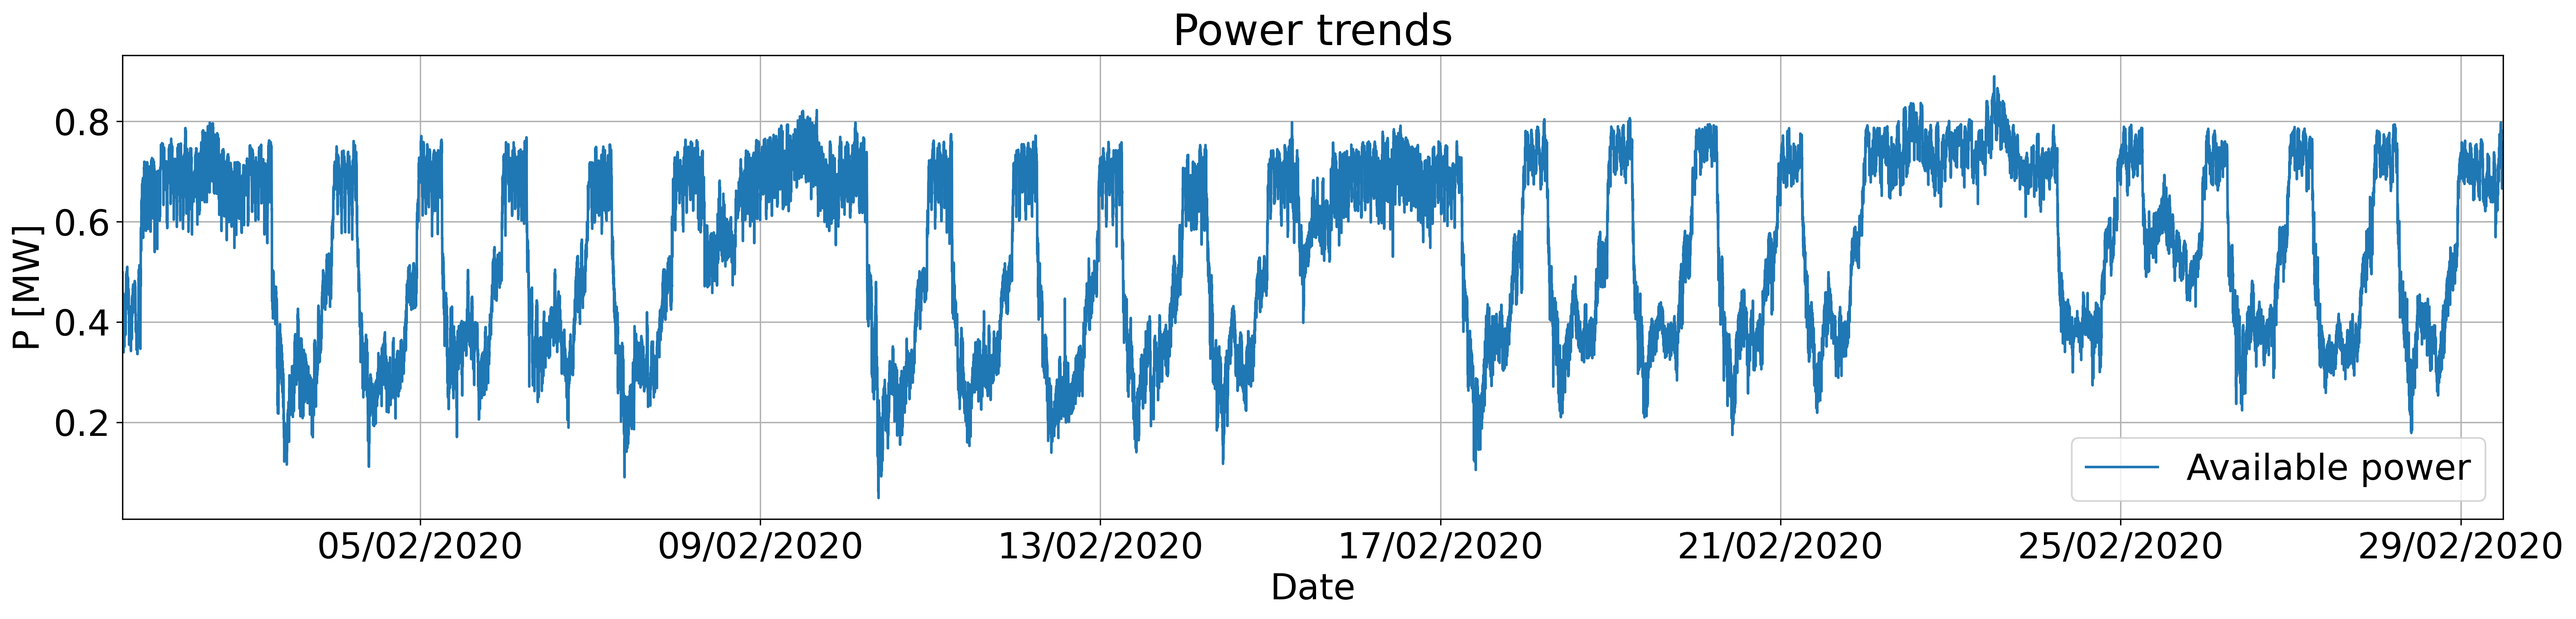

In [25]:
plt.figure(figsize=(25, 5) )

font = {'weight' : 'normal','size'   : 21}
plt.rc('font', **font)
plt.xlim(737456.5, 737484.5)
plt.plot(dfinal.index, dfinal.AvailablePower/1000000, label='Available power')
plt.xlabel('Date')
plt.ylabel('P [MW]')
plt.title('Power trends')

import matplotlib.dates as md
ax=plt.gca()
xfmt = md.DateFormatter('%d/%m/%Y')
ax.xaxis.set_major_formatter(xfmt)

plt.legend()
plt.grid()
axes = plt.gca()
plt.savefig("Available_power", bbox_inches = 'tight')

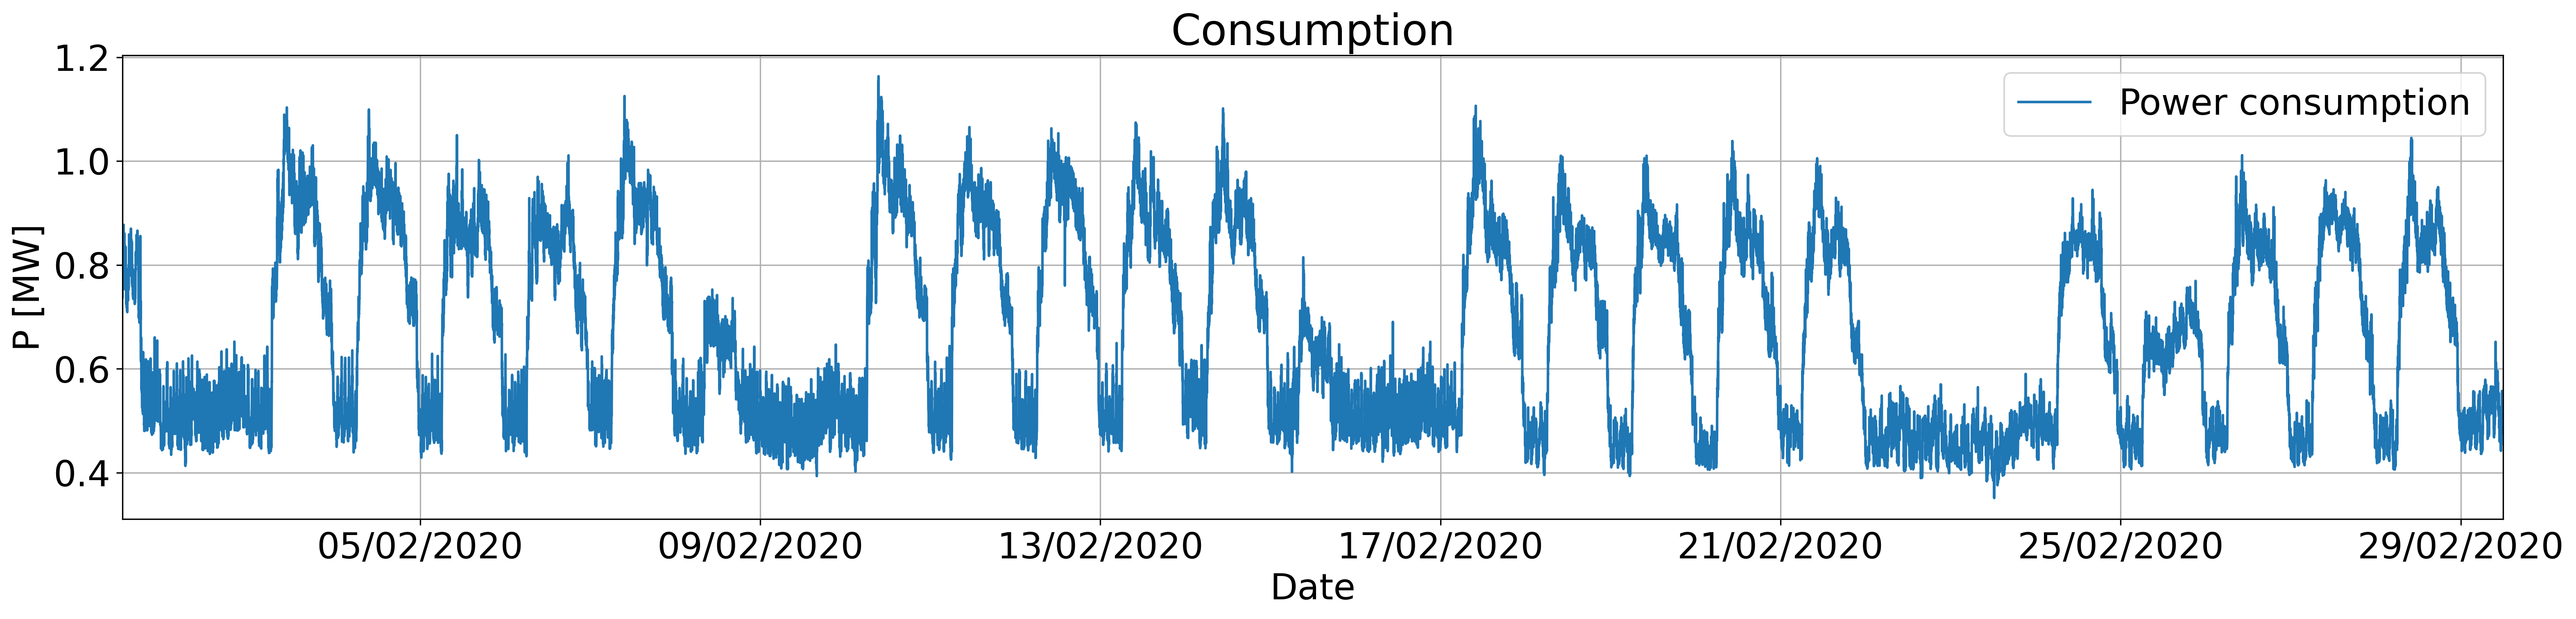

In [26]:
plt.figure(figsize=(25, 5) )

font = {'weight' : 'normal','size'   : 21}
plt.rc('font', **font)
plt.xlim(737456.5, 737484.5)
plt.plot(dfinal.index, dfinal.P/1000000, label='Power consumption')
plt.xlabel('Date')
plt.ylabel('P [MW]')
plt.legend()
plt.grid()

import matplotlib.dates as md
ax=plt.gca()
xfmt = md.DateFormatter('%d/%m/%Y')
ax.xaxis.set_major_formatter(xfmt)

plt.title('Consumption')
plt.savefig("power_consumption", bbox_inches = 'tight')

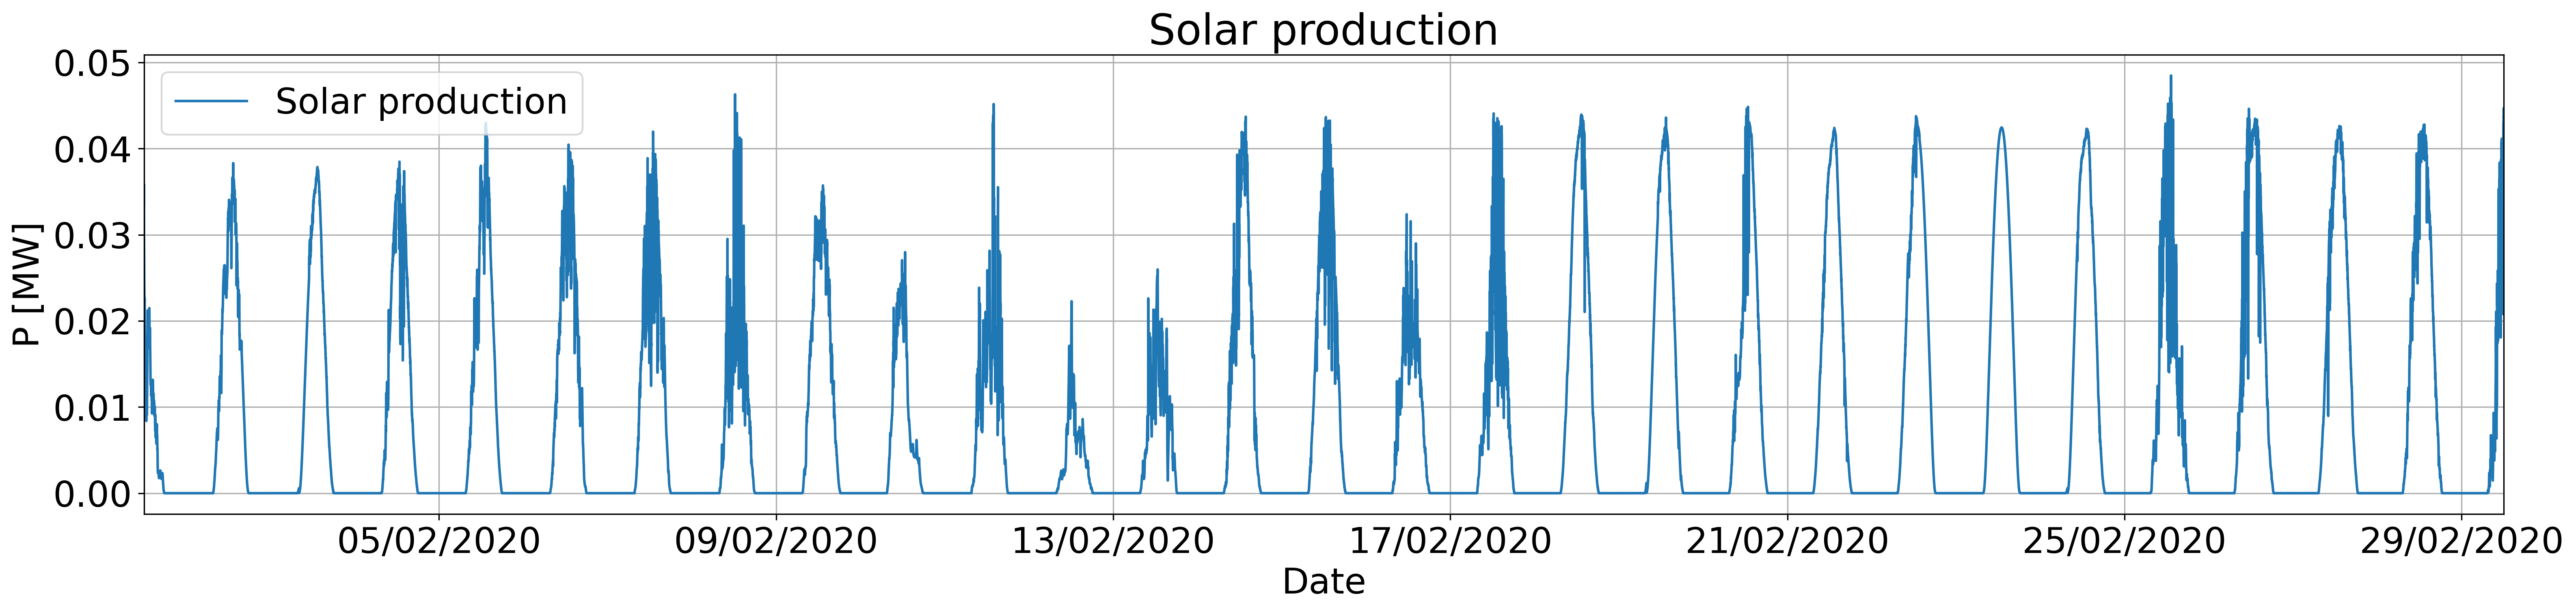

In [27]:
plt.figure(figsize=(25, 5) )

font = {'weight' : 'normal','size'   : 21}
plt.rc('font', **font)
plt.xlim(737456.5, 737484.5)
plt.plot(dfinal.index, dfinal.ActPwr/1000000, label='Solar production')
plt.xlabel('Date')
plt.ylabel('P [MW]')

plt.title('Solar production')


import matplotlib.dates as md
ax=plt.gca()
xfmt = md.DateFormatter('%d/%m/%Y')
ax.xaxis.set_major_formatter(xfmt)

plt.legend()
plt.grid()
axes = plt.gca()
plt.savefig("power_production", bbox_inches = 'tight')

# Build dataframes

In [28]:
dfinal = getData(local = True)

In [29]:
a1, a2, a3, a4, a5, v1, v2, v3, v4, t5, d6 = getDatasets(dfinal)

# PCA

In [44]:
dt = a1.copy()
dataset = 'a5'

In [45]:
val = dt.values
scaler = StandardScaler() 
val_standardized = scaler.fit_transform(val) # standardizing the data

pca = PCA()
val_standardized_PCA = pca.fit(val_standardized)

Text(0.5, 0, 'Nº of Comp.')

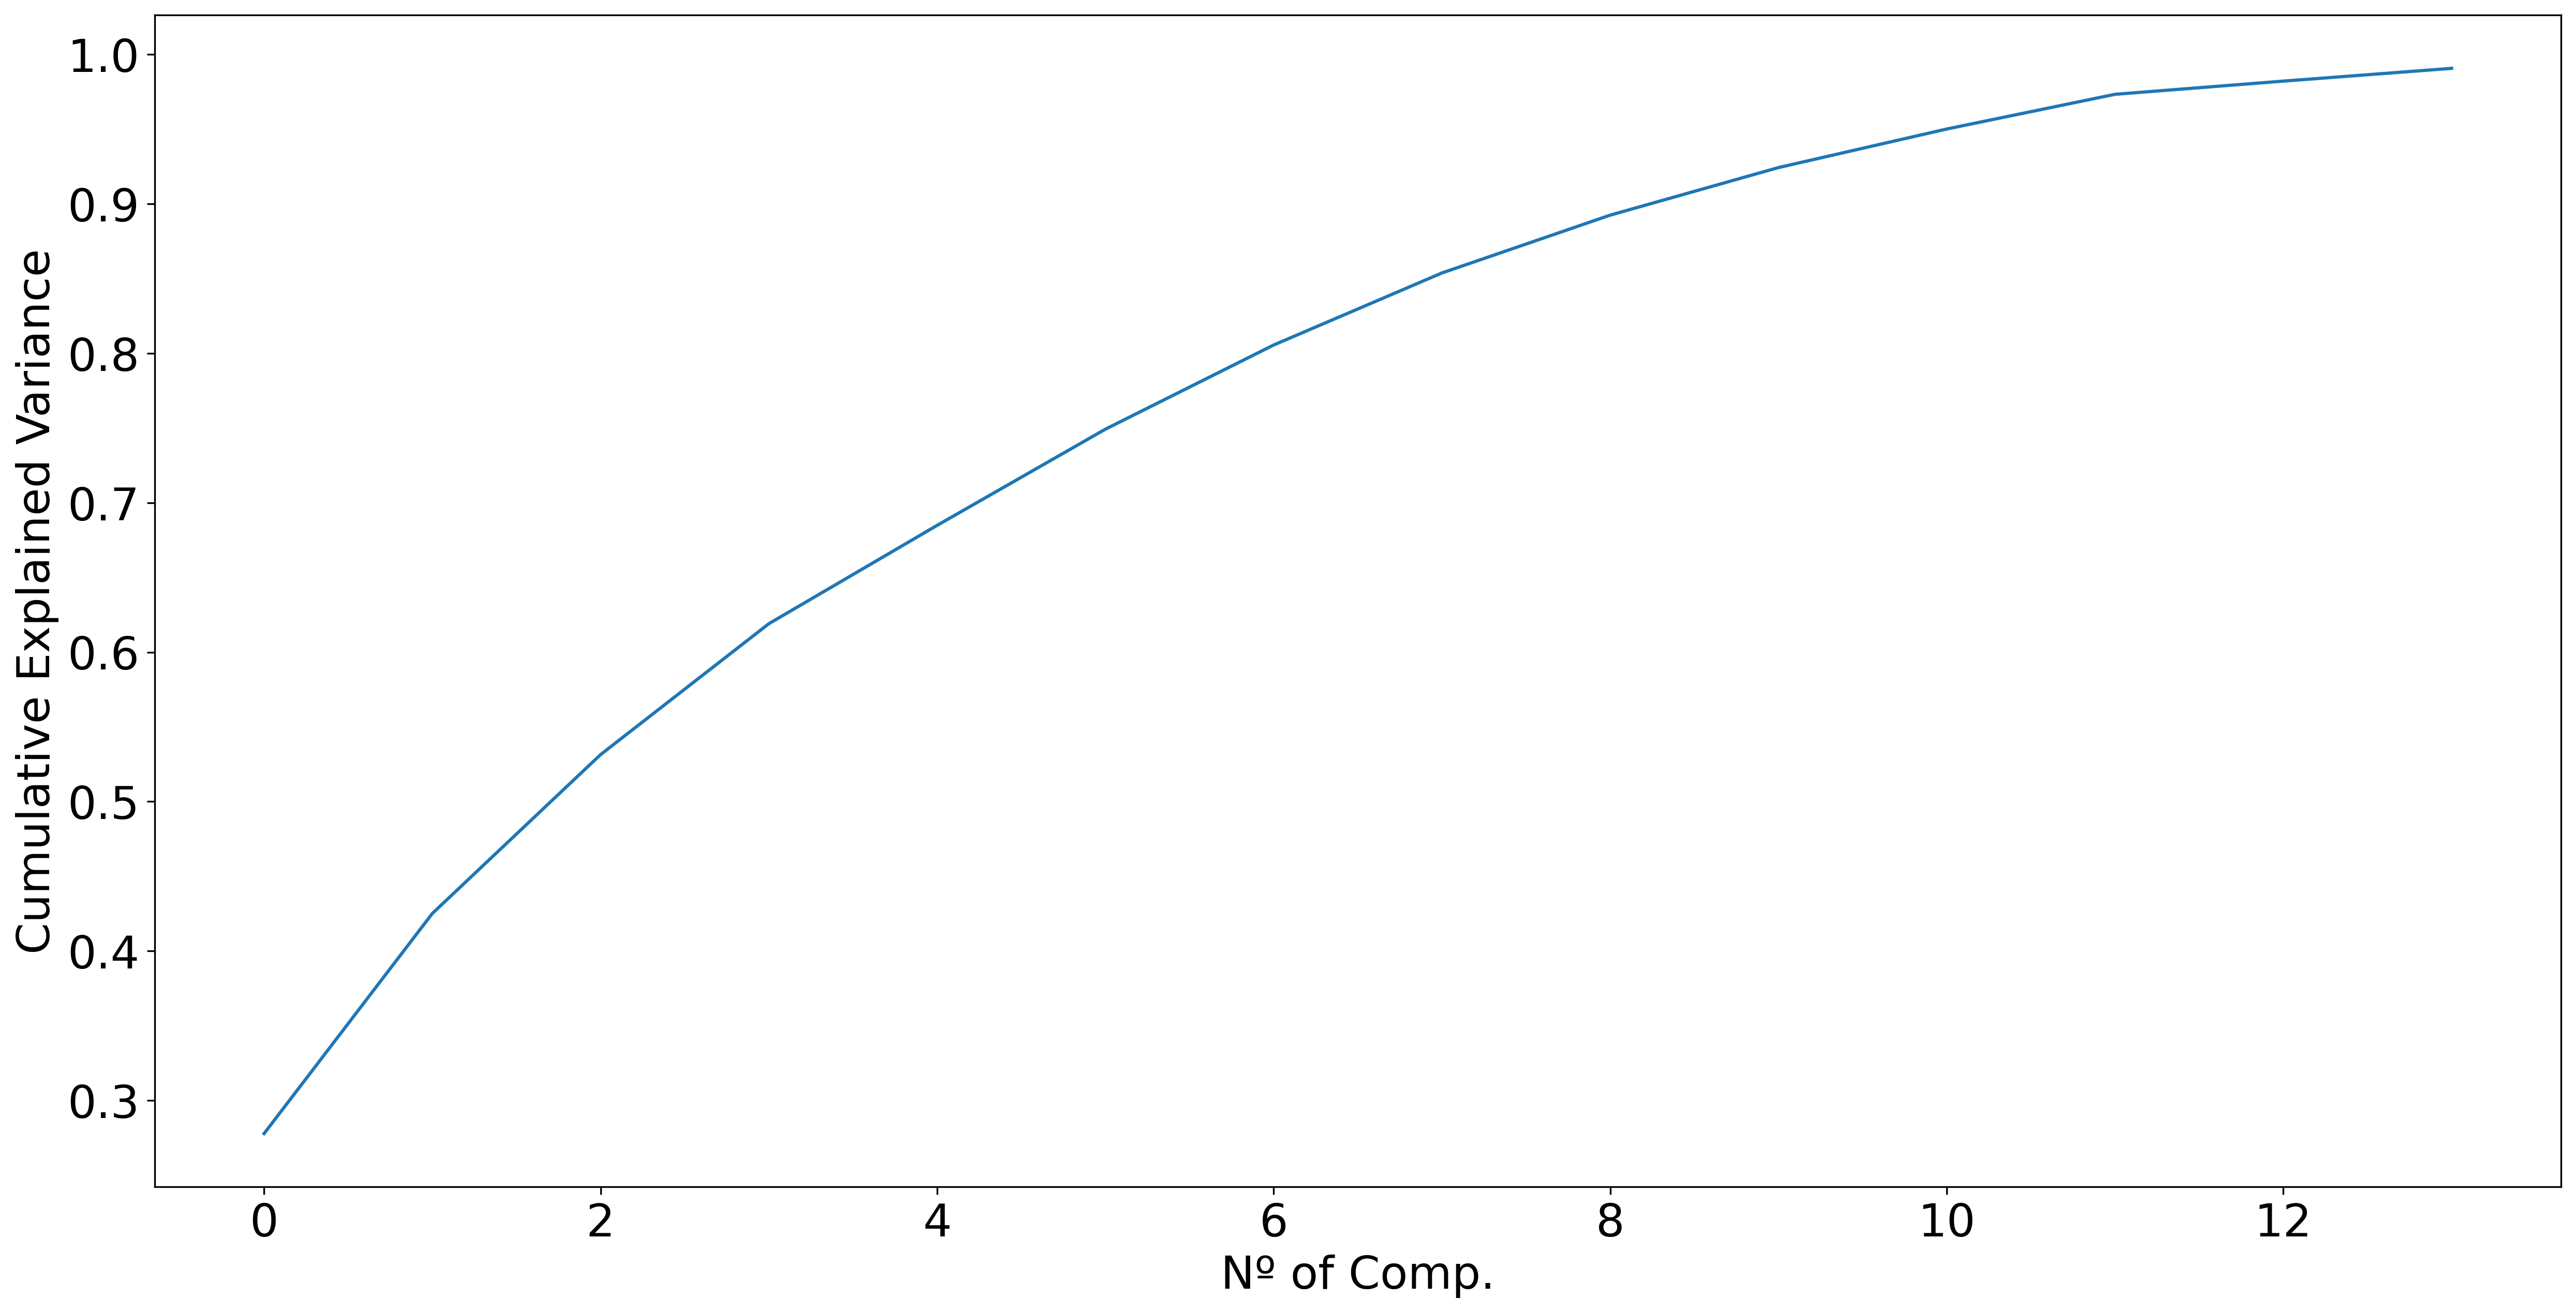

In [63]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Cumulative Explained Variance');
plt.xlabel('Nº of Comp.')



In [51]:
n_comps = 15
pca = PCA(n_comps)  
values_pca = pca.fit_transform(val_standardized)
pca = PCA(n_components = 0.99)
X_pca = pca.fit_transform(val_standardized) 
print(pca.n_components_) 

14


In [52]:
pd.DataFrame(pca.components_, columns = dt.columns)

,Avg_DHI,Avg_GHI,Avg_DNI,Avg_POA,T_amb_avg,RH_avg,AH_avg,p_amb_avg,rho_act,v_avg,v_dir_vectavg,Theoretical Value,ActPwr,P,hour,day_of_month,day_of_week,month,holiday,AvailablePower
0,0.304009,0.377426,0.322232,0.196239,0.295004,-0.277190,-0.039201,-0.046537,-0.290510,0.156184,-0.036387,0.367926,0.368682,0.167618,0.127743,-0.005968,-0.036564,0.097576,-0.015965,-0.135090
1,-0.002434,-0.111167,-0.115718,0.259283,0.237296,0.179384,0.420313,0.304559,-0.074140,-0.126489,0.011017,-0.081723,-0.126141,0.393033,0.171606,-0.054467,-0.153773,-0.352930,0.016703,-0.411737
2,-0.202954,-0.174762,-0.128772,0.447018,0.360075,-0.188269,0.109042,-0.136298,-0.410603,-0.059762,0.031041,-0.187614,-0.177580,-0.290098,0.191640,-0.032528,0.219211,0.153053,-0.075850,0.277952
3,0.139243,0.159829,0.107340,0.066172,0.047740,0.183013,0.224940,0.201245,0.053603,-0.372879,-0.367409,0.167183,0.155572,-0.234512,-0.256050,0.096038,0.416779,-0.335014,-0.057661,0.253371
4,-0.111511,0.000776,0.087124,0.074868,0.073039,-0.347913,-0.331837,0.245276,0.098850,-0.000251,0.033224,-0.086529,-0.064426,-0.068549,0.154222,0.581402,-0.081706,-0.372819,0.372806,0.063526
5,-0.223887,0.059617,0.245429,0.066902,0.081365,-0.291354,-0.258533,0.546306,0.257462,-0.110838,-0.045428,-0.096049,-0.061592,-0.008941,0.001671,-0.540837,0.035496,0.097323,-0.166820,0.003186
6,0.172560,0.061930,-0.056945,-0.002701,0.046995,0.142420,0.223510,0.254744,0.083021,0.254084,0.572490,0.102862,0.075424,-0.195752,0.027381,-0.236891,0.167301,-0.013684,0.494386,0.206275
7,-0.074434,-0.016463,0.010237,0.141182,0.109937,-0.006943,0.077774,-0.010845,-0.109097,-0.020173,-0.361090,-0.027689,-0.023873,-0.064540,-0.498176,-0.149517,-0.484673,0.164436,0.520730,0.063337
8,-0.091391,0.038796,0.095379,0.056275,0.134943,-0.004410,0.123633,0.150284,-0.045920,0.434792,0.253232,-0.046779,-0.025376,-0.118917,-0.491865,0.189007,-0.247033,-0.209633,-0.502854,0.118484
9,0.175023,-0.017564,-0.150682,0.138689,0.003639,-0.123789,-0.145677,-0.033714,-0.010816,-0.679749,0.520019,0.090414,0.076636,0.039379,-0.286850,0.078005,-0.176501,0.109334,-0.093199,-0.032694


In [62]:
n_pcompss = pca.n_components_ 
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcompss)]
features = dt.columns
most_important = [features[most_important[i]] for i in range(n_pcompss)]
most_important

['Avg_GHI',
 'AH_avg',
 'Avg_POA',
 'day_of_week',
 'day_of_month',
 'p_amb_avg',
 'v_dir_vectavg',
 'holiday',
 'holiday',
 'v_avg',
 'Avg_DNI',
 'day_of_week',
 'Avg_DHI',
 'Avg_POA']

In [ ]:
most_important_names.pop(5)

In [ ]:
dt = a5

In [ ]:
final_features = features()

In [ ]:
dt_selected = dt[final_features].copy()

In [ ]:
f = plt.figure(figsize=(30, 20))
ax = sns.heatmap(dt_selected.corr(), linewidths=3.5, annot=True, annot_kws={"size": 25}, fmt=".2f", cbar=True, cbar_kws = dict({"shrink": 1},use_gridspec=False,location="top"))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 30)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 30)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)


ax.figure.savefig("corr1.png", bbox_inches='tight')